In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np
import matplotlib.pyplot as plt
from pylab import *
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import os
from graphviz import Source
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz/release/bin' #Esta línea es necesaria para que graphviz funcione en windows
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import imblearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

In [2]:
## Cargado del dataset original
data = pd.read_csv("C:/Users/pjlu_/Desktop/DataminingUPB.csv", sep=";")
data.rename(columns={'Humedad en aire':'hum_aire',
                          'Humedad en suelo 1':'hum_gnd_1',
                          'Humedad en suelo 2':'hum_gnd_2',
                          'Unnamed: 2':'unidad',
                    'Unnamed: 4':'unidad_3',
                    'Unnamed: 6':'unidad_5',
                    'Unnamed: 8':'unidad_7',
                    'Unnamed: 10':'unidad_9',
                    'Unnamed: 12':'unidad_11'},
                 inplace=True)

## Borrado de columna de unidades
data = data.drop(["unidad","unidad_3","unidad_5","unidad_7","unidad_9","unidad_11"],axis =1)

##Separado de los datos correspondientes al sujeto 1
data2 = data.drop(["EstadosPlanta_2","N_hojas_2","hum_gnd_2",],axis =1)

##Separado de los datos correspondientes al sujeto 2
data3 = data.drop(["EstadosPlanta_1","N_hojas_1","hum_gnd_1"],axis =1)

## Homogeneizado en encabezados de la tabla de datos de sujeto 1 y agregado de columna para la identificaciòn de estos
data2.rename(columns={'hum_gnd_1':'hum_gnd','EstadosPlanta_1':'EstadosPlanta','N_hojas_1':'N_hojas'},inplace=True)
data2['sujeto']= "1"

## Homogeneizado en encabezados de la tabla de datos de sujeto 2 y agregado de columna para la identificaciòn de estos
data3.rename(columns = {'hum_gnd_2':'hum_gnd','EstadosPlanta_2':'EstadosPlanta','N_hojas_2':'N_hojas'},inplace=True)
data3['sujeto'] = "2"

##Unión de los datos de sujetos 1 y 2 en un nuevo dataset
data4 = pd.concat([data2,data3])

## Eliminado de filas donde falte al menos un dato
data4 = data4.dropna(axis=0, how="any")

## Eliminado de las columnas fecha y N_hojas
data_nfecha = data4.drop(["Time","N_hojas"],axis = 1)



In [3]:
data_nfecha.head()

,Temperatura,CO2,hum_aire,hum_gnd,Luminosidad,EstadosPlanta,sujeto
0,2599,6315,704,50709.0,16389,1.0,1
1,2598,6388,700,50709.0,16390,1.0,1
2,2598,6517,698,50710.0,16390,1.0,1
3,2591,6493,694,50710.0,16397,1.0,1
4,2590,6315,693,50709.0,16398,1.0,1


## Árbol de decisión

In [4]:
colnames = data_nfecha.columns.values.tolist()
predictores = colnames
target = colnames[5]
predictores.remove('EstadosPlanta')

In [5]:
## Divisiòn de la data en datos de entrenamiento y test

#Creaciòn de columna Training, donde el 75% seràn True y el 25% False (75 % pertenecen a los datos de entrenamiento y 25% a test) 
data_nfecha["Training"] = np.random.uniform(0,1, len(data_nfecha))<=0.75 

## Separaciòn de los datos de entrenamiento y test
train, test = data_nfecha[data_nfecha["Training"]==True], data_nfecha[data_nfecha["Training"]==False]

In [6]:
## Creaciòn del árbol de decisiòn

X_train = train[predictores]
Y_train = train[target]

X_test = test[predictores]
Y_test = test[target]

arbol = DecisionTreeClassifier(criterion="entropy", max_depth=20, min_samples_split=20, random_state=99)

In [7]:
## Implementaciòn de Crossvalidaton
cv = KFold(n_splits= X_train.shape[0], shuffle=True, random_state=1)
scores=cross_val_score(arbol, X_train, Y_train, scoring="f1_macro", cv = 10, n_jobs=-1)
preds=cross_val_predict(arbol, X_train, Y_train, cv = 10, n_jobs=-1)

In [8]:
print(scores)

[0.54960605 0.52694655 0.46129883 0.47855791 0.45123982 0.49644666
 0.42186932 0.32955174 0.28172553 0.44765573]


(array([10015.,     0.,     0.,     0.,     0.,  1955.,     0.,     0.,
            0.,   172.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <BarContainer object of 10 artists>)

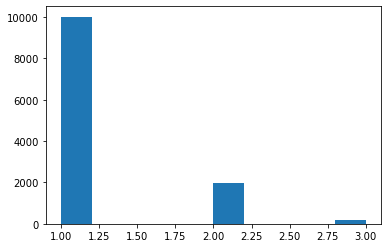

In [9]:
plt.hist(preds)

## Matriz de confusión

In [10]:
pd.crosstab(Y_train,preds, rownames=["Real"],colnames=["Predicciones"])

Predicciones,1.0,2.0,3.0
Real,,,
1.0,9063,1092,24
2.0,905,699,145
3.0,47,164,3


In [11]:
target_names = ['1', '2', '3']
print(classification_report(Y_train, preds, target_names=target_names))

              precision    recall  f1-score   support

           1       0.90      0.89      0.90     10179
           2       0.36      0.40      0.38      1749
           3       0.02      0.01      0.02       214

    accuracy                           0.80     12142
   macro avg       0.43      0.43      0.43     12142
weighted avg       0.81      0.80      0.81     12142



<AxesSubplot:>

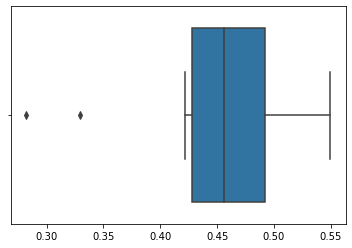

In [12]:
sns.boxplot(scores)

## Random forest

In [13]:
forest = RandomForestClassifier(n_jobs=-1, oob_score=True,n_estimators=500,criterion="entropy", max_depth=20, min_samples_split=20, random_state=99)


In [14]:
## Implementaciòn de Crossvalidaton
cv = KFold(n_splits= X_train.shape[0], shuffle=True, random_state=1)
scores_forest=cross_val_score(forest, X_train, Y_train, scoring="f1_macro", cv = 10, n_jobs=-1)
preds_forest=cross_val_predict(forest, X_train, Y_train, cv = 10, n_jobs=-1)

In [15]:
print(scores_forest)

[0.56967244 0.54572438 0.51316172 0.4867734  0.34659003 0.35316561
 0.39745308 0.35517177 0.23956989 0.36477849]


(array([10404.,     0.,     0.,     0.,     0.,  1692.,     0.,     0.,
            0.,    46.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <BarContainer object of 10 artists>)

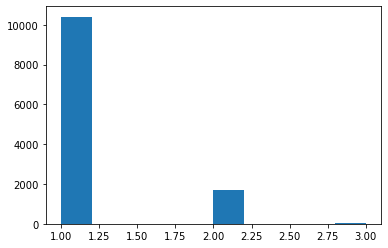

In [16]:
plt.hist(preds_forest)

In [17]:
pd.crosstab(Y_train,preds_forest, rownames=["Real"],colnames=["Predicciones"])

Predicciones,1.0,2.0,3.0
Real,,,
1.0,9241,938,0
2.0,1140,563,46
3.0,23,191,0


In [18]:
target_names = ['1', '2', '3']
print(classification_report(Y_train, preds_forest, target_names=target_names))

              precision    recall  f1-score   support

           1       0.89      0.91      0.90     10179
           2       0.33      0.32      0.33      1749
           3       0.00      0.00      0.00       214

    accuracy                           0.81     12142
   macro avg       0.41      0.41      0.41     12142
weighted avg       0.79      0.81      0.80     12142



<AxesSubplot:>

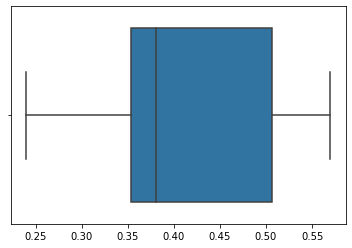

In [19]:
sns.boxplot(scores_forest)

## Random Forest con opción de data balanceada

In [20]:
forest2 = RandomForestClassifier(n_jobs=-1, oob_score=True,n_estimators=500,criterion="entropy",class_weight='balanced', max_depth=20, min_samples_split=20, random_state=99)


In [21]:
## Implementaciòn de Crossvalidaton
cv = KFold(n_splits= X_train.shape[0], shuffle=True, random_state=1)
scores_forest2=cross_val_score(forest2, X_train, Y_train, scoring="f1_macro", cv = 10, n_jobs=-1)
preds_forest2=cross_val_predict(forest2, X_train, Y_train, cv = 10, n_jobs=-1)

In [22]:
print(scores_forest2)

[0.5025311  0.47175957 0.44094185 0.50659629 0.57422671 0.64577582
 0.49622349 0.2836619  0.31321496 0.47176016]


(array([8806.,    0.,    0.,    0.,    0., 2798.,    0.,    0.,    0.,
         538.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <BarContainer object of 10 artists>)

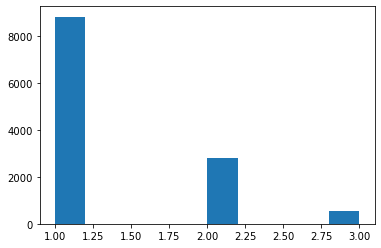

In [23]:
plt.hist(preds_forest2)

In [24]:
pd.crosstab(Y_train,preds_forest2, rownames=["Real"],colnames=["Predicciones"])

Predicciones,1.0,2.0,3.0
Real,,,
1.0,8569,1557,53
2.0,235,1041,473
3.0,2,200,12


In [25]:
target_names = ['1', '2', '3']
print(classification_report(Y_train, preds_forest2, target_names=target_names))

              precision    recall  f1-score   support

           1       0.97      0.84      0.90     10179
           2       0.37      0.60      0.46      1749
           3       0.02      0.06      0.03       214

    accuracy                           0.79     12142
   macro avg       0.46      0.50      0.46     12142
weighted avg       0.87      0.79      0.82     12142



<AxesSubplot:>

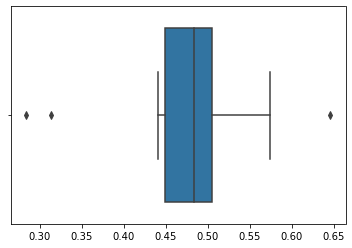

In [26]:
sns.boxplot(scores_forest2)

## Datos Normalizados

In [27]:
X_norm_train = StandardScaler().fit_transform(X_train)
X_norm_test = StandardScaler().fit_transform(X_test)

X_norm_train

array([[-0.33781928, -1.06956873, -0.33221648, -1.1569792 , -0.67375281,
        -0.85736058],
       [-0.34626925, -0.19000219, -0.36560704, -1.1569792 , -0.67292049,
        -0.85736058],
       [-0.34626925,  1.36430031, -0.38230233, -0.91477576, -0.67292049,
        -0.85736058],
       ...,
       [-0.27021951,  1.01488347, -0.29882591,  1.26505515, -0.69456062,
         1.1663704 ],
       [-0.5913184 , -1.58766956, -0.34056412,  1.74946202, -0.68374056,
         1.1663704 ],
       [-0.72651793, -1.44308328, -0.39064997,  1.26505515, -0.67208818,
         1.1663704 ]])

## Arbol de decisión normalizado

In [28]:
arbol_norm = DecisionTreeClassifier(criterion="entropy", max_depth=20, min_samples_split=20, random_state=99)

## Implementaciòn de Crossvalidaton
cv = KFold(n_splits= X_norm_train.shape[0], shuffle=True, random_state=1)
scores_norm=cross_val_score(arbol_norm, X_norm_train, Y_train, scoring="f1_macro", cv = 10, n_jobs=-1)
preds_norm=cross_val_predict(arbol_norm, X_norm_train, Y_train, cv = 10, n_jobs=-1)

(array([10012.,     0.,     0.,     0.,     0.,  1958.,     0.,     0.,
            0.,   172.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <BarContainer object of 10 artists>)

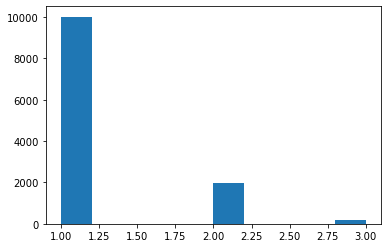

In [29]:
plt.hist(preds_norm)

## Matriz de confusiòn para datos normalizados - Arbol de decisión

In [30]:
pd.crosstab(Y_train,preds_norm, rownames=["Real"],colnames=["Predicciones"])

Predicciones,1.0,2.0,3.0
Real,,,
1.0,9061,1094,24
2.0,904,700,145
3.0,47,164,3


In [31]:
target_names = ['1', '2', '3']
print(classification_report(Y_train, preds_norm, target_names=target_names))

              precision    recall  f1-score   support

           1       0.91      0.89      0.90     10179
           2       0.36      0.40      0.38      1749
           3       0.02      0.01      0.02       214

    accuracy                           0.80     12142
   macro avg       0.43      0.43      0.43     12142
weighted avg       0.81      0.80      0.81     12142



<AxesSubplot:>

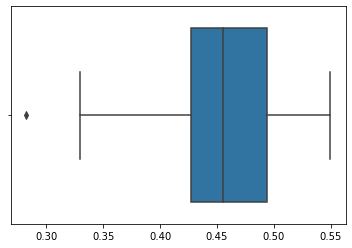

In [32]:
sns.boxplot(scores_norm)

## Random Forest normalizado

In [33]:
forest_norm = RandomForestClassifier(n_jobs=-1, oob_score=True,n_estimators=500,criterion="entropy",class_weight='balanced', max_depth=4, min_samples_split=20, random_state=99)

## Implementaciòn de Crossvalidaton
cv = KFold(n_splits= X_norm_train.shape[0], shuffle=True, random_state=1)
scores_forest_norm=cross_val_score(forest_norm, X_norm_train, Y_train, scoring="f1_macro", cv = 10, n_jobs=-1)
preds_forest_norm=cross_val_predict(forest_norm, X_norm_train, Y_train, cv = 10, n_jobs=-1)

(array([7644.,    0.,    0.,    0.,    0., 3581.,    0.,    0.,    0.,
         917.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <BarContainer object of 10 artists>)

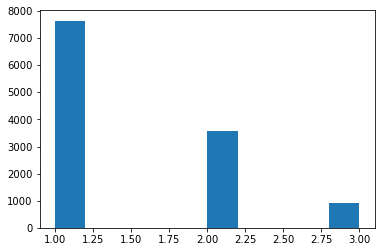

In [34]:
plt.hist(preds_forest_norm)

## Matriz de confusiòn para datos normalizados - Random Forest

In [35]:
pd.crosstab(Y_train,preds_forest_norm, rownames=["Real"],colnames=["Predicciones"])

Predicciones,1.0,2.0,3.0
Real,,,
1.0,7590,2395,194
2.0,54,1054,641
3.0,0,132,82


In [36]:
target_names = ['1', '2', '3']
print(classification_report(Y_train, preds_forest_norm, target_names=target_names))

              precision    recall  f1-score   support

           1       0.99      0.75      0.85     10179
           2       0.29      0.60      0.40      1749
           3       0.09      0.38      0.15       214

    accuracy                           0.72     12142
   macro avg       0.46      0.58      0.46     12142
weighted avg       0.88      0.72      0.77     12142



<AxesSubplot:>

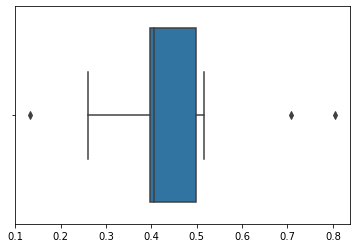

In [37]:
sns.boxplot(scores_forest_norm)

## Analisis de componentes principales

In [38]:
pca = PCA()
pca.fit(X_norm_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) +1

In [39]:
pca.explained_variance_ratio_

array([0.32630183, 0.20112352, 0.16654153, 0.1547483 , 0.12989585,
       0.02138898])

In [40]:
#Y

In [41]:
#X

In [42]:
X['pred'] = arbol.predict_proba(X)

In [43]:
pd.cut(arbol.predict_proba(X).flatten(), 5)

NameError: name 'X' is not defined

In [ ]:
for i in range (1,11):
    arbol = DecisionTreeClassifier(criterion="entropy", max_depth=i, min_samples_split=20, random_state=99)
    arbol.fit(X,Y)
    cv = KFold(n_splits= X.shape[0], shuffle=True, random_state=1)
    scores_prueba=cross_val_score(arbol, X, Y, scoring="accuracy", cv = 10, n_jobs=-1)
    score_prueba = np.mean((scores_prueba))
    print("Score para i: ",i," es de ", score_prueba)
    print("    ", arbol.feature_importances_)

In [ ]:
data_nfecha.columns